In [1]:
#import the needed Libraries

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from PIL import Image
import pandas as pd

from IPython import display
import cv2
import pickle

In [2]:
#create a write
writer = tf.summary.create_file_writer('./new_loss')

In [3]:
#The Convolutional Variational Auto-Encoder Proper. 
#Define the network class

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):   #latent_dim is the dimensional of the latent space
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(80, 60, 3)),   #Note Input Image Size
              tf.keras.layers.Conv2D(
                  filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=128, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=256, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )

        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=40*30*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(40,30, 32)), #Note the strides formula!
              tf.keras.layers.Conv2DTranspose(
                  filters=32,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=128,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=256,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=3, kernel_size= 3, strides=(1, 1), padding="SAME", activation='sigmoid'),
            ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(64, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):   #encode the images into the latent space
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    #the reparametrization trick suggests that we randomly sample 'e' from a unit Gaussian,
    #and then shift the randomly sampled 'e' by the latent distribution's mean 'mu' and scale it 
    #by the latent distribution's variance 'rho'.

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):  #decodes the latent space into the image
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    kl_tolerance = 0.5
    #import pdb; pdb.set_trace()
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_logit), axis=[1, 2, 3]))
    kl_loss = - 0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar),axis=1)
    kl_loss = tf.reduce_mean(tf.maximum(kl_loss, kl_tolerance * latent_dim))
    loss_sum = reconstruction_loss + kl_loss
    
#     with writer.as_default():
#         tf.summary.scalar('Graph of' + '_reconstruction_loss', reconstruction_loss, step=epoch)
#         tf.summary.scalar('Graph of' + '_kl_loss', kl_loss, step=epoch)
#         tf.summary.scalar('Graph of' + '_loss_sum',loss_sum, step=epoch)
#         writer.flush()
    return loss_sum, reconstruction_loss, kl_loss

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss, r_loss, kl_loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return r_loss, kl_loss

In [5]:
epochs = 100
latent_dim = 256
num_examples_to_generate = 12

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [6]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(16,16))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('./images/soccer/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

275.39957 128.0 147.39957


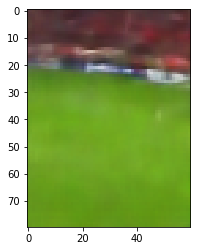

In [65]:
add = 'chebay0626.jpg'    
test_inputs = np.array(Image.open(add))   
test_inputs = test_inputs.astype('float32')

test_inputs /= 255.

test_inputs = test_inputs.reshape(1,80,60,3)

#from tf.keras.models import load_model

def check_image(image,latent_dim):
    model.load_weights('last_iteration.h5')
    loaded_model = model
    #sample = model.sample()
    #sample = sample[0].numpy().reshape(1,80,60,3)
    encod, logvar = loaded_model.encode(image)
    repar = loaded_model.reparameterize(encod, logvar)
    img = loaded_model.decode(repar)
    loss_sum, kl_loss, recon_loss = compute_loss(loaded_model, test_inputs)
    loss_sum, kl_loss, recon_loss = loss_sum.numpy(),recon_loss.numpy(),kl_loss.numpy()
    print(loss_sum, kl_loss, recon_loss)     #here for a group of pictures, we may want to 
    img = np.squeeze(img)
    return plt.imshow(img)

img = check_image(test_inputs,256)

275.54175 128.0 147.54176


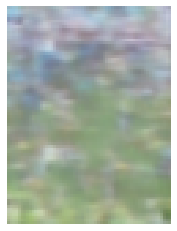

In [64]:
img = check_image(test_inputs,256)
plt.axis('off')
plt.savefig('generative_example',quality = 95)

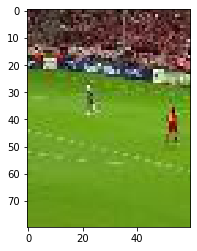

In [11]:
add ='chebay0626.jpg'   
check_inputs = np.array(Image.open(add)) 
plt.imshow(check_inputs)

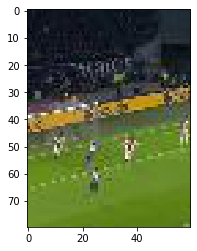

In [13]:
add ='ajvbm0203.jpg'   
check_inputs = np.array(Image.open(add)) 
plt.imshow(check_inputs)

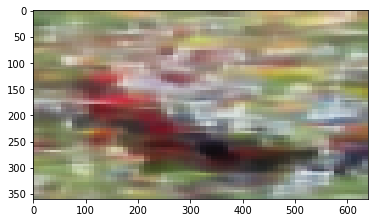

In [225]:
#folder = glob.glob('./test_images/not_football/*') test-image folder
loss_df = pd.DataFrame()

loss_list = []

def image_check_resize(folder,latent_dim):
    for file in folder:
        li = file.split('/')[2]
        name = li.split('.')[0]
        with open(file, 'r+b') as f:
            with Image.open(f) as image:
                cover = image.resize((60, 80))
                test_inputs = np.array(cover)   
                test_inputs = test_inputs.astype('float32')
                test_inputs /= 255.
                test_inputs = test_inputs.reshape(1,80,60,3)
                model.load_weights('last_iteration.h5')   #load model and weights
                loaded_model = model
                encod, logvar = loaded_model.encode(test_inputs)
                repar = loaded_model.reparameterize(encod, logvar)
                img = loaded_model.decode(repar)
                loss_sum, kl_loss, recon_loss = compute_loss(loaded_model, test_inputs)
                loss_list.append({'loss_sum':loss_sum.numpy(),'reconstruction_loss':recon_loss.numpy(),'kl_loss':kl_loss.numpy()}) #append loss to list   
                df = loss_df.append(loss_list, ignore_index=True)
                img = np.squeeze(img)
                im = Image.fromarray(np.uint8((img)*255))
                im = im.resize((640, 360))
                im.save('./test_images_recons_more/not_football/{}.jpg'.format(name), image.format)
                df.to_csv('loss_recon_more_nft.csv')
    return plt.imshow(im)

show = image_check_resize(folder,latent_dim)

In [226]:
df = pd.read_csv('loss_recon_more_ft.csv')
df1 = pd.read_csv('loss_recon_more_nft.csv')
df2 = pd.read_csv('loss_recon_more_aft.csv')

In [172]:
df.head(5)

,Unnamed: 0,loss_sum,reconstruction_loss,kl_loss
0,0,401.550018,128.0,273.550018
1,1,274.192383,128.0,146.192398
2,2,265.061554,128.0,137.061554
3,3,209.112701,128.0,81.112694


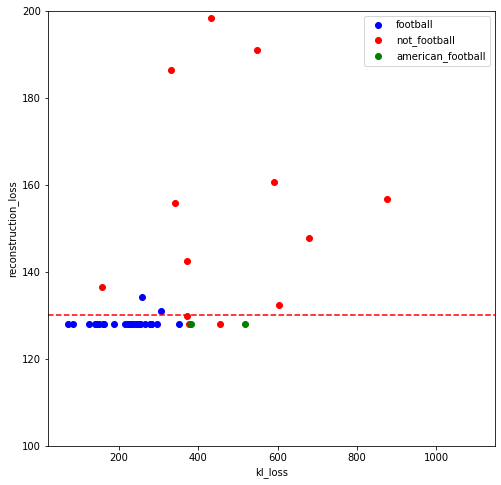

In [228]:
fig1 = plt.figure(figsize=(8,8))
ax = plt.scatter(y = df['reconstruction_loss'], x = df['kl_loss'], color='b')  #football
ax1 = plt.scatter(y = df1['reconstruction_loss'], x = df1['kl_loss'], color='r')  #not_football
ax3 = plt.scatter(y = df2['reconstruction_loss'], x = df2['kl_loss'], color='g')  #american_football
plt.axhline(y=130, color='r', linestyle='--')
plt.legend((ax,ax1,ax3),('football','not_football','american_football'))
plt.ylabel('reconstruction_loss')
plt.xlabel('kl_loss')
plt.ylim((100,200))
#plt.savefig('various_rec_loss')